### <i>Hands on Machine Learning with Scikit-Learn and Tensorflow</i>


# Chapter 2 - California House Price Prediction 

(Part 1 of 3)

The objective of this model is to predict house prices given a California census data set.

In [1]:
# housekeeping stuff to set the page width as wide as possible in this notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import tarfile
import pandas as pd
import numpy as np
import hashlib
from six.moves import urllib

%matplotlib inline
import matplotlib.pyplot as plt

# Fetch and load the data

The data we will use is old but fine for learning.

In [3]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

In [4]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """Download raw data and store it to disk."""
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [5]:
def load_housing_data(housing_path=HOUSING_PATH):
    """Return a Pandas data frame containing the raw data."""
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# Explore the data a bit to get a feel for it

In [6]:
fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Each row in the data represents a district of California. There are 10 attributes. The <code>info()</code> and <code>describe()</code>method from Pandas is useful to show a quick description of the data.

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Going back to the top 5 rows above, the ocean_proximity field looks like it is probably catagorical. You can find out what catagories exist using <code>value_counts()</code>

In [9]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Plot a histogram of all numerical values.







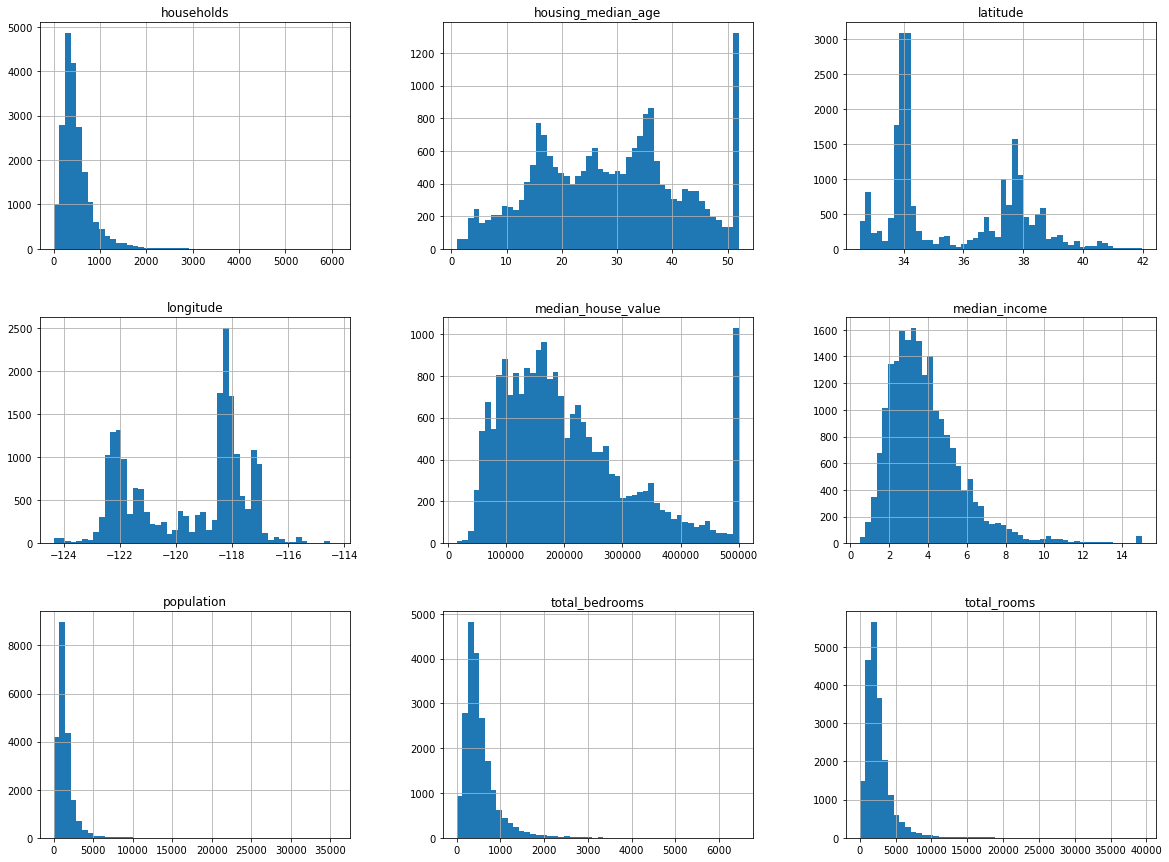

In [10]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

### A few things to note:

* The median income is not in USD. Turns out it has been scaled and capped at 15 for higher median incomes and at 0.5 for lower median incomes. It's important to discover such preprocessed fields.
* Housing median age and house value were also capped. The latter might be a serious issue since this is the target field, so the model may never learn values beyond that limit. Would be important to check whether or not this is important or not in the real world. If prices are needed beyond that limit in the model output, there would be two possible options:
    * Collect proper lables and remove the caps
    * Remove those districts from the data
* These attributes have differnt scales
* Many histograms are tail heavy. This may make it harder for some ML algorithms to detect patterns. Will try transforming these attributes later to have a more bell shaped distributions

# Create a Test Set

This is theoretically simple, just split out 20% of the data at random and move on. Here's how that could be done: 

In [11]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

Here's how that data could be used:

In [12]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


This works, but it's not perfect. If you run the program again, it will generate a different test set! Over time you will get to see the whole dataset which is what you want to avoid. 

One solution is to save the test set on the first run then always load it in subsequent runs. Another option is to set the random number generator's seed before calling <code>np.random.permutation()</code>. But both of these approaches will break next time you fetch an updated dataset. A common solution is to use each instance's identifier to decide if it's to be in the training or test set (assuming instances have a unique and immutable identifier). For example, compute a hash of each instance's ID, keep only the last byte of the hash and put the instance in the test set if this value is lower or equal to 51 (~20% of 256). This ensures the test set will remain consistent across multiple runs even if you refresh the dataset. The new test will contain 20% of the new instances but it will not contain any instance that was previously in the training set. 

In [13]:
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

Since there is no immutable, unique column in the data, we will need to add one. We could use the row number as the ID but then it would be important (in a real project) to ensure that any new data that is added to the dataset is appended at the end:

In [14]:
housing_with_id = housing.reset_index()  # Adds an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

Another approach would be to concatenate the lattitude and longitude fields into a unique id:

In [15]:
del housing_with_id['index']
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

Scikit-Learn provides a number of functions to split datasets into multiple subsets in various ways. The simplest is <code>train_test_split()</code> which basically does the above with some additional features. There is a 'random_state' parameter that you use to specify the random seed (42, the meaning of life, etc) and you can pass it multiple datasets with an identical number of rows and it will split them on the same indices (useful if you have a separate DataFrame for lables).

In [16]:
from sklearn.model_selection import train_test_split

# get back to clean data
housing = load_housing_data()
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# Avoiding Sampling Bias

Suppose experts told you that median income is a very important field for predicting median house prices. You would then want to make sure your test set is representative of the various categories of incomes in the whole dataset. Since the income field is a continuous numerical attribute you first need to create an income category attribute. Let's look at the median income histogram.

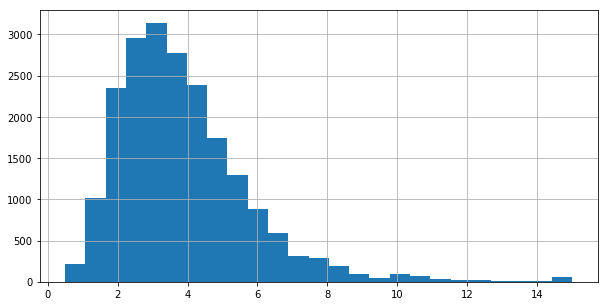

In [17]:
_ = housing["median_income"].hist(bins=25, figsize=(10,5))

Most of the income values are between 2 and 5 (tens of thousands of dollars) but some go far beyond 6. It's important to have the right number of instances in your dataset for each stratum to avoid bias. Should not have too many strata and each one should be large enough. 

Create an income category by dividing the median income by 1.5 (to limit the number of income categories), rounding up using <code>ceil()</code> to have discrete categories and then merging all the categories less than 5 into category 5:

In [18]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

Now we are ready to do stratified sampling based on the income category

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Lets see if it worked

In [20]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [21]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [22]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

Now should remove the income_cat attribute so the data is back to it's original state

In [23]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

First make sure you have put the test set aside and you are only exploring the training set. If the training set is very large, you may want to sample an exploration set to make explorations fast. Here, that's not necessary.

Create a copy to play with without harming the training set:

In [24]:
housing = strat_train_set.copy()

## Visualising Geographical Data

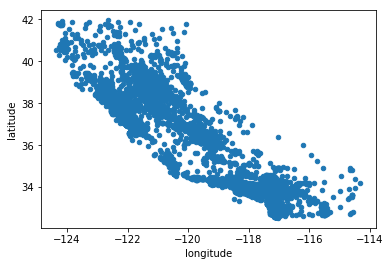

In [25]:
_ = housing.plot(kind="scatter", x="longitude", y="latitude")

Looks like California alright, but not very informative yet. 

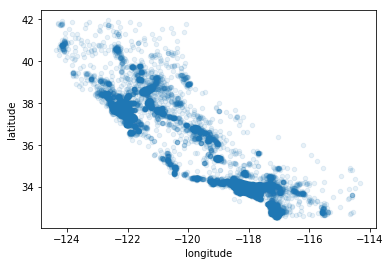

In [26]:
_ = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

... better, can see high density areas. But need to play around with the visualization paramaters a bit more to start to see patterns. Lets look at housing prices. The radius of each circle represents the district's population (option s). The color represents the price (option c)

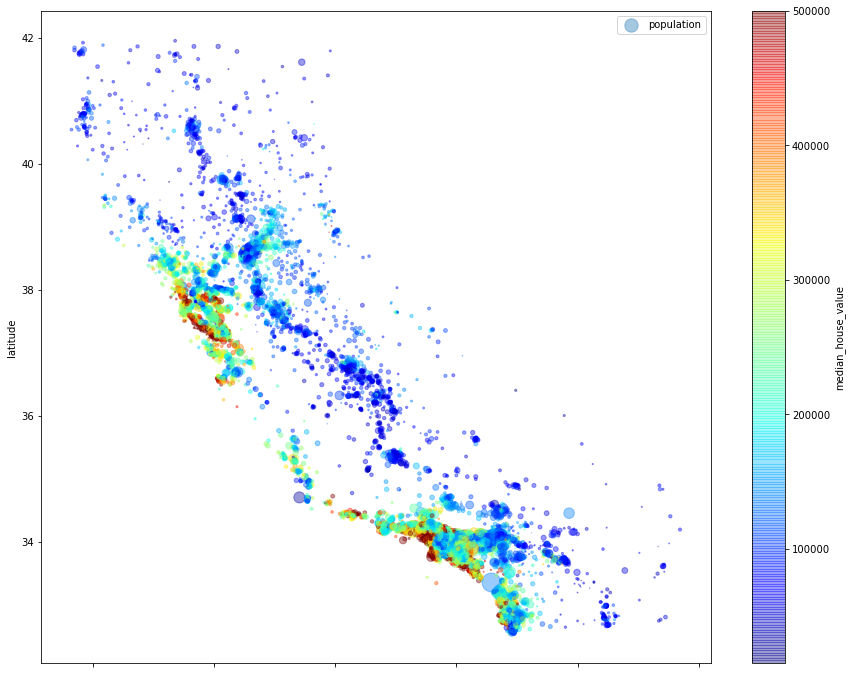

In [27]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(15, 12),
            s=housing["population"]/100, label="population",
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True
            )
_ = plt.legend()

The housing prices are related to the location as can be seen above, e.g. close to the ocean, and to the population density (so pretty much as you might have predicted). It will probably be useful to use a clustering algorithm to detect the main clusters and add new features that measure the proximity to the cluster centers. The ocean proximity attribute might also be useful although as you go north it seems to be less relevant. 

# Looking for Correlations


Since the dataset is not so large it's easy to compute the <b><i>Standard Correlation Coefficient</i></b> (also called Pearson's r) between every pair of attribtes using the <code>corr()</code> method:

In [28]:
corr_matrix = housing.corr()

Now let's look at how each attribute correlates with the median house value:

In [29]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The Standard Correlation Coefficient ranges from -1 to +1. When it's close to 1 it means there is a strong positive correlation and when it's close to -1 it means there is a strong negative correlation. When it's zero, there is no correlation. This is a good way to see linear correlations, but will not catch non-linear ones. 


Another way to spot correlations is to use Pandas' <code>scatter_matrix()</code> function which plots every numerical attribute against every other numerical attribute. Since there are 11 attributes you would get $11^2 = 121$ plots. So let's just focus on a few promising ones: 

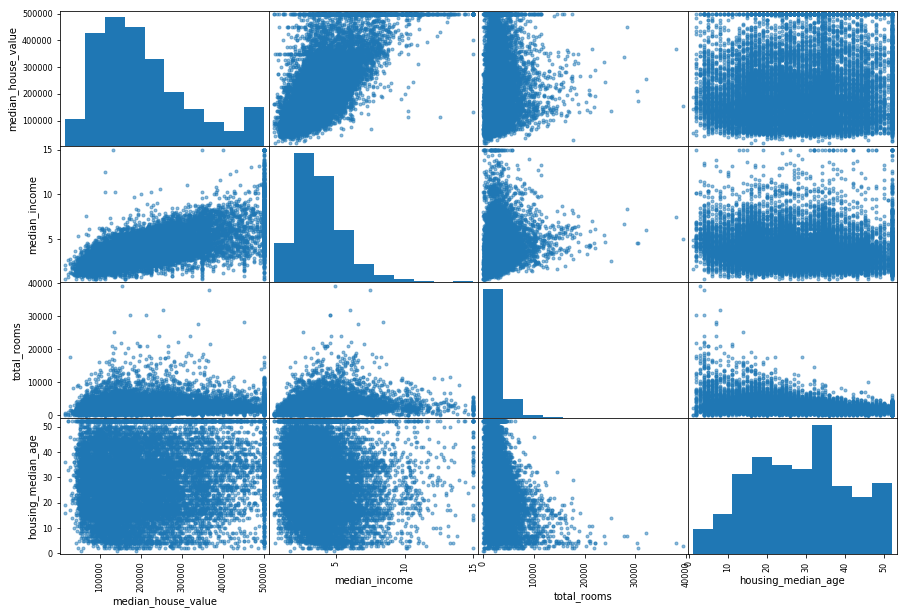

In [30]:
from pandas.tools.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
_ = scatter_matrix(housing[attributes], figsize=(15, 10))

The most promising one is median_income vs. median_house_value:

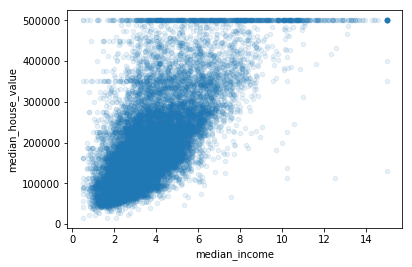

In [31]:
_ = housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

A few takeaways from this plot:

There is a very strong correlation. The price cap we noticed earlier is clearly visible at 500k but there are other horizontal lines at 450k, 350k and maybe around 280k, maybe even more. You might want to remove the corresponding districts to prevent the algorithms from learning to reproduce these quirks


# Experimenting with Attribute Combinations

Some of the attributes are not all that useful by themselves. For example, it's not interesting to know the total number of rooms, but the number of rooms per household would be interesting. Let's create a few new fields:

In [32]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

Now lets look at the correlation matrix again:

In [33]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Interesting! It looks like as house value goes up, the bedrooms_per_room attribute goes down! Apparently as houses get more expensive they tend to have less bedrooms per total number of rooms. The number of rooms per household is also more informative than the total number of rooms in a district - the large the houses the more expensive they are (duh).

This round of exploration doesn't have to be completely through. The point is to start off on the right foot and quickly gain insights that will help prototype. But it's an iterative process and once the prototype is up and running you can get more insights and come back to revise.

________________________________________________________________________________________________________________________________________________________________


<b>That's it for this part. Now pickle the data and make it ready for import in part 2.</b>

Will persist <code>strat_train_set</code> since that's the cleanest dataset and is the one we want to use for actual machine learning.

In [34]:
import pickle, os

if not os.path.isdir('./data'):
    os.makedirs('./data')

with open('./data/prt1.pkle', 'wb') as f:
    pickle.dump([strat_train_set, strat_test_set], f, pickle.HIGHEST_PROTOCOL)